## 1. **Configure the Notebook:** 

In [1]:
# Import necessary libraries
import numpy as np
from xarray_healpy import HealpyGridInfo, HealpyRegridder
from pangeo_fish.grid import center_longitude
import xarray as xr
import pandas as pd
import xdggs
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.hmm.optimize import EagerBoundsSearch
from pangeo_fish.utils import temporal_resolution
from pangeo_fish.hmm.prediction import Gaussian1DHealpix,Gaussian2DCartesian
from tlz.functoolz import curry
from pint_xarray import unit_registry as ureg
import healpy as hp

# earth_radius defines the radius of the Earth used for distance calculations.
earth_radius = ureg.Quantity(6371, "km")
# maximum_speed sets the maximum allowable speed for the tagged fish.
maximum_speed = ureg.Quantity(60, "km / day")

# It will factor the allowed maximum displacement of the fish.
adjustment_factor = 5
# truncate sets the truncating factor for computed maximum allowed sigma for convolution process.
truncate = 4
tolerance = 1e-6
# Defines default chunk size for optimisation.
chunk_time = 24
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_xy = {"time": chunk_time, "x": -1, "y": -1}
default_chunk_cells = {"time": chunk_time, "cells": -1}

/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


In [2]:
import xarray as xr
emission = xr.open_dataset('../A19124/combined.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )
emission

<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [3]:
def sigma_to_radian(sigma, earth_radius_km=6371):
    """
    Convert sigma (arc length) to radians.
    
    Parameters:
    - sigma: float, the arc length in the same unit as earth_radius_km.
    - earth_radius_km: float, the Earth's radius in kilometers (default: 6371 km).
    
    Returns:
    - float: sigma in radians.
    """
    return np.sqrt(4*np.pi/(12*4096**2)) * sigma
    #return sigma/earth_radius_km


# Apply the function to sigma = 1.06
sigma = 1.06292
sigma_radian = sigma_to_radian(sigma)

print(f"Sigma in radians: {sigma_radian}")
earth_radius_ = xr.DataArray(earth_radius, dims=None)

timedelta = temporal_resolution(emission["time"]).pint.quantify().pint.to("h")
grid_resolution = earth_radius_ * emission["resolution"].pint.quantify()

maximum_speed_ = xr.DataArray(maximum_speed, dims=None).pint.to("km / h")
max_grid_displacement = maximum_speed_ * timedelta * adjustment_factor / grid_resolution
max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate

max_grid_displacement_radian = maximum_speed_ * timedelta * adjustment_factor / earth_radius_
max_sigma_radian = max_grid_displacement_radian.pint.to("dimensionless").pint.magnitude / truncate

# Applying max sigma over the emission matrices
emission.attrs["max_sigma"] = max_sigma_radian.item()
print(max_sigma.item())

print(max_sigma_radian)
emission

Sigma in radians: 0.00026555527939709026
1.963306279189256
0.0004905038455501491


/home/ecap/pangeo-fish/pangeo_fish/utils.py:122: FutureWarning: Hour.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  timedelta = to_offset(freq).delta.to_numpy()


<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [4]:
emission = emission.stack(cells=("y", "x"))
emission = emission.drop_vars(['x','y'])
# Set required attributes cleanly
emission["cell_ids"].attrs["grid_name"] = "healpix"
#emission_1D["cell_ids"].attrs["nest"] = True
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
emission["cell_ids"].attrs = {key: value for key, value in emission["cell_ids"].
                              attrs.items() if key in attrs_to_keep}
emission

/tmp/ipykernel_78063/299093097.py:2: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'cells'} to avoid an error in the future.
  emission = emission.drop_vars(['x','y'])


<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
    cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

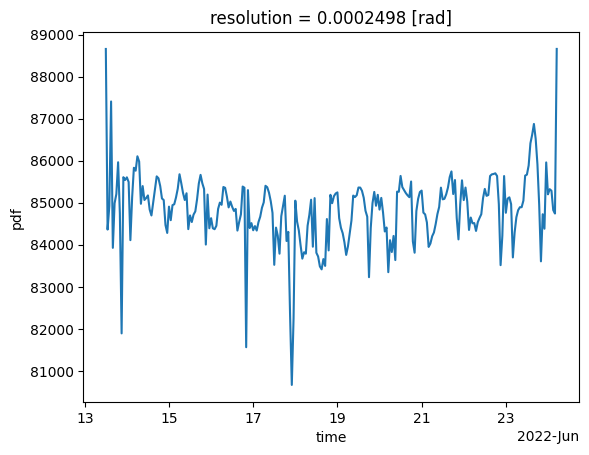

In [5]:

emission['pdf'].count(dim='cells').plot()

In [6]:
#emission_regridded_plus = emission_regridded_plus.compute()  # WHAT DOES IT CHANGE?
emission_1D = emission.assign_coords({'cell_ids':lambda ds:ds['cell_ids'].compute()}).sortby('cell_ids').pipe(xdggs.decode)
predictor_factory = curry(
    Gaussian1DHealpix,
    cell_ids=emission_1D["cell_ids"].data,
    grid_info=emission_1D.dggs.grid_info,
    truncate=4.0,
    weights_threshold=1e-8,
    pad_kwargs={"mode": "constant", "constant_value": 0},
    optimize_convolution=True,
)
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [7]:
##############################
# MANUELLEMENT AJOUT DU SIGMA
#############################
optimized = EagerEstimator(
            sigma=0.00026555527939709026,
            predictor_factory=predictor_factory)

optimized

EagerEstimator(predictor_factory=<class 'pangeo_fish.hmm.prediction.Gaussian1DHealpix'>, sigma=0.00026555527939709026, predictor=None)

In [8]:
emission_1D = emission_1D.compute()

In [9]:
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (cells) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, cells) float64 400MB nan nan nan nan ... nan nan nan nan
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [ ]:
states_1D = optimized.predict_proba(emission_1D)
states_1D = states_1D.to_dataset().chunk(default_chunk_cells).persist()
states_1D

In [ ]:
states_1D.pipe(xdggs.decode).isel(time=2).compute().states.dggs.explore(alpha=0.8)

In [ ]:
states_1D_from_2D = xr.open_dataset('states_from_emission_2D.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )
states_1D_from_2D

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Pour une meilleure palette de couleurs

# Définir une palette de couleurs plus douce
sns.set(style="whitegrid", palette="muted")

test2 = states_1D_from_2D #2D
test = states_1D #healpix
im = np.zeros([12*4096**2])

fig, axes = plt.subplots(3, 6, figsize=(15, 10))  # Pour un meilleur arrangement des sous-graphes
axes = axes.flatten()

for k in range(18):
    idx1 = test.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data1 = test.states.isel(time=k).dropna('cells').compute().data
    im[idx1] = data1
    
    idx2 = test2.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data2 = test2.states.isel(time=k).dropna('cells').compute().data
    print(len(idx1), len(idx2))
    data1 = im[idx2]
    im[idx1] = 0.0
    
    # Tracer les données avec plus de détails
    axes[k].plot(data1, color='dodgerblue', lw=2, label="Healpix")  # Couleur plus douce
    axes[k].plot(data2, color='darkorange', lw=2, label="2D")  # Couleur différente pour la comparaison
    axes[k].set_title(f"Time = {k+1}", fontsize=14)  # Ajouter un titre pour chaque subplot
    axes[k].set_xlabel("Cell ID", fontsize=12)  # Ajouter des labels d'axe
    axes[k].set_ylabel("Value", fontsize=12)
    axes[k].legend()
    axes[k].grid(True, which='both', linestyle='--', linewidth=0.5)  # Ajouter une grille légère

# Ajuster l'espacement pour que les subplots ne se chevauchent pas
plt.tight_layout()
plt.savefig('convol_comp_emission_with_accoustic.png')
plt.show()


## 2D surface plus grande --> valeur moins importante .
## 

In [ ]:
import numpy as np
import hvplot.pandas  # Extension pour hvplot
import holoviews as hv
import panel as pn

hv.extension('bokeh')  # Utiliser la bibliothèque Bokeh pour les rendus interactifs
pn.extension()

# Préparer les données pour un affichage interactif
test2 = states_1D_from_2D  # 2D
test = states_1D  # healpix
im = np.zeros([12 * 4096**2])

def get_data_for_time(k):
    """Récupérer les données pour un pas de temps spécifique."""
    idx1 = test.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data1 = test.states.isel(time=k).dropna('cells').compute().data
    im[idx1] = data1
    
    idx2 = test2.states.isel(time=k).dropna('cells').cell_ids.compute().data
    data2 = test2.states.isel(time=k).dropna('cells').compute().data
    data1 = im[idx2]
    im[idx1] = 0.0
    
    return data1, data2, idx2

def plot_data(k):
    """Tracer les données pour un pas de temps spécifique avec des lignes ordonnées."""
    # Récupérer les données alignées
    data1, data2, idx2 = get_data_for_time(k)

    # Créer un DataFrame avec les indices et les valeurs
    df1 = pd.DataFrame({"Cell ID": idx2, "Value": data1, "Type": "Healpix"})
    df2 = pd.DataFrame({"Cell ID": idx2, "Value": data2, "Type": "2D"})

    # Trier par "Cell ID" pour garantir un tracé correct
    df1 = df1.sort_values("Cell ID")
    df2 = df2.sort_values("Cell ID")

    # Combiner les deux DataFrames pour faciliter le tracé
    df = pd.concat([df1, df2])

    # Tracer les lignes sans liaison incorrecte entre points
    plot = df.hvplot(
        kind="line",  # ou "scatter" si vous voulez des points séparés
        x="Cell ID",
        y="Value",
        by="Type",  # Une série différente pour chaque type
        line_width=2,
        title=f"Time = {k+1}",
        xlabel="Cell ID",
        ylabel="Value",
        grid=True,
        color=["dodgerblue", "darkorange"],
        legend="top",
    )
    return plot

# Créer un widget curseur pour naviguer dans le temps
slider = pn.widgets.IntSlider(name='Time Step', start=0, end=257, step=1, value=0)

# Associer le curseur au graphique
interactive_plot = pn.bind(plot_data, k=slider)

# Organiser l'interface utilisateur avec Panel
dashboard = pn.Column(
    "# Healpix VS 2D convolution",
    slider,
    interactive_plot
)

# Afficher l'interface utilisateur
dashboard.servable()
